<a href="https://colab.research.google.com/github/turna1/GenAI/blob/main/gemini_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Vertex AI SDK for Python


In [2]:
! pip3 install --upgrade --user google-cloud-aiplatform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.0 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Restart current runtime


The restart process might take a minute or so.


In [1]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

After the restart is complete, continue to the next step and authnticate your google account



In [2]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information (Colab only)

Find the project id by clicking on the project you cretaed in vertex ai This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [3]:
if "google.colab" in sys.modules:
    # Define project information
    PROJECT_ID = "ioextendedottawa"  # @param {type:"string"}
    LOCATION = "us-central1"  # @param {type:"string"}

    # Initialize Vertex AI
    import vertexai

    vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [4]:
from vertexai.preview.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image,
    Part,
)

## Use the Gemini Pro model

The Gemini Pro (`gemini-pro`) model is designed to handle natural language tasks, multiturn text and code chat, and code generation.


### Load the Gemini Pro model


In [5]:
model = GenerativeModel("gemini-pro")

### Generate text from text prompts




In [7]:
responses = model.generate_content("Act like a travelblogger and give me a plan for 6 days to spend in las-vegas?", stream=True)

for response in responses:
    print(response.text, end="")

**Day 1**:

* Check into your hotel on the Las Vegas Strip.
* Have lunch at one of the many restaurants in your hotel or along the Strip.
* Visit the Bellagio Fountains for a free show every 15-30 minutes.
* Have dinner at one of the many celebrity chef restaurants on the Strip.
* See a Cirque du Soleil show such as "Mystère" or "O".

**Day 2**:

* Have breakfast at one of the many buffets on the Strip.
* Visit the Grand Canyon on a day trip from Las Vegas.
* Take a helicopter tour of the Grand Canyon for a truly unforgettable experience.
* Have dinner at one of the many restaurants in the Grand Canyon Village.
* Return to Las Vegas in the evening.

**Day 3**:

* Have breakfast at your hotel or one of the many coffee shops along the Strip.
* Visit the Fremont Street Experience, a pedestrian mall with casinos, shops, and restaurants.
* See the Fremont Street Experience light show, the largest LED screen in the world.
* Have dinner at one of the many steakhouses in Las Vegas.
* See a mag

#### Model parameters
 You can experiment with different model parameters to see how the results change.


In [9]:
generation_config = GenerationConfig(
    temperature=0.9,
    top_p=1.0,
    top_k=32,
    candidate_count=1,
    max_output_tokens=8192,
)

responses = model.generate_content(
    "Act like a travelblogger and give me a plan for 6 days to spend in las-vegas??",
    generation_config=generation_config,
    stream=True,
)

for response in responses:
    print(response.text, end="")

**Day 1**:

* Check into your hotel on the Las Vegas Strip.
* Have lunch at one of the many restaurants in your hotel or along the Strip.
* Visit the Bellagio Fountains for a free show every 15-30 minutes.
* Have dinner at one of the many celebrity chef restaurants on the Strip.
* See a Cirque du Soleil show such as "Mystère" or "O".

**Day 2**:

* Have breakfast at one of the many buffets on the Strip.
* Visit the Grand Canyon on a day trip from Las Vegas.
* Take a helicopter tour of the Grand Canyon for a truly unforgettable experience.
* Have dinner at one of the many restaurants in the Grand Canyon Village.
* Return to Las Vegas in the evening.

**Day 3**:

* Have breakfast at your hotel or one of the many coffee shops along the Strip.
* Visit the Fremont Street Experience, a pedestrian mall with casinos, shops, and restaurants.
* Take a ride on the SlotZilla zip line for a unique perspective of Fremont Street.
* Have dinner at one of the many restaurants in Fremont Street.
* See a

## Use the Gemini Pro Vision model




### Load the Gemini Pro Vision model


In [10]:
multimodal_model = GenerativeModel("gemini-pro-vision")

### Define helper functions

Define helper functions to load and display images.


In [11]:
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)

def get_url_from_gcs(gcs_uri: str) -> str:
    # converts gcs uri to url for image display.
    url = "https://storage.googleapis.com/" + gcs_uri.replace("gs://", "").replace(" ", "%20")
    return url

def print_multimodal_prompt(contents: list):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if isinstance(content, Image):
            display_images([content])
        elif isinstance(content, Part):
            url = get_url_from_gcs(content.file_data.file_uri)
            IPython.display.display(load_image_from_url(url))
        else:
            print(content)

### **Extract and Transform**


Copying gs://cloud-samples-data/generative-ai/image/320px-Felis_catus-cat_on_snow.jpg...
/ [1 files][ 17.4 KiB/ 17.4 KiB]                                                
Operation completed over 1 objects/17.4 KiB.                                     
-------Prompt--------


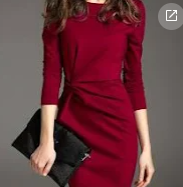

Describe this image?

-------Response--------
 The image is of a woman wearing a red dress. The dress is fitted and has a pleated skirt. The woman is also wearing a black handbag.

In [15]:

#upload the images first in google colab
# Load from local file
image = Image.load_from_file("/content/dress3.png")

# Prepare contents
prompt = "Describe this image?"
contents = [image, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------


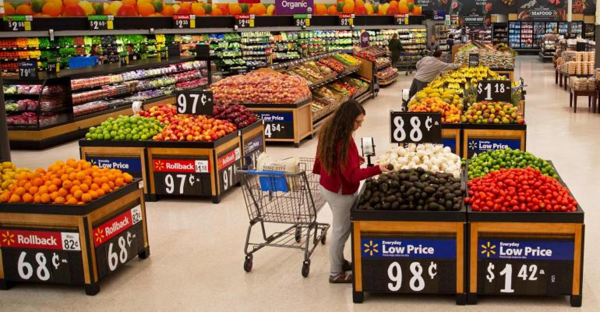

extract the price from the market photo and give me it in Json format

-------Response--------
 ```json
{
  "prices": [
    {
      "item": "organic bananas",
      "price": "$1.99/lb"
    },
    {
      "item": "apples",
      "price": "$1.48/lb"
    },
    {
      "item": "oranges",
      "price": "$0.68/lb"
    },
    {
      "item": "limes",
      "price": "$1.97/lb"
    },
    {
      "item": "avocados",
      "price": "$0.88/each"
    },
    {
      "item": "garlic",
      "price": "$1.42/lb"
    },
    {
      "item": "tomatoes",
      "price": "$1.18/pint"
    }
  ]
}
```

In [30]:
#upload the images first in google colab
# Load from local file
image = Image.load_from_file("/content/Walmart-price signage-product dept.jpg")

# Prepare contents
prompt = "extract the price from the market photo and give me it in Json format"
contents = [image, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

### Personal Stylist Prompt: Multipule image input and Explainability test

-------Prompt--------


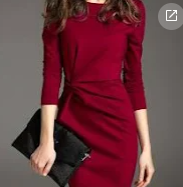

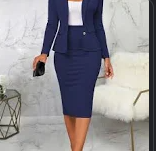

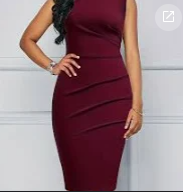

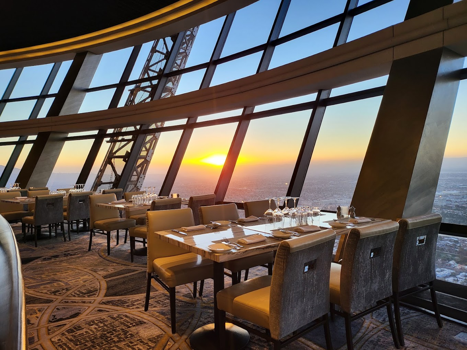

Suggest me the suitable dress to wear in this restaurant for better photograph

-------Response--------
 The first dress is suitable for a dinner date or a night out. The second dress is suitable for a business meeting or a job interview. The third dress is suitable for a wedding or a formal event. The fourth dress is suitable for a casual outing or a day at the beach.

In [18]:
image1 = Image.load_from_file("/content/dress3.png")
image2 = Image.load_from_file("/content/dress2.png")
image3 = Image.load_from_file("/content/dress1.png")
image4 = Image.load_from_file("/content/restaurant.jpg")


# Prepare prompts
prompt1 = "Suggest me the suitable dress to wear in this restaurant for better photograph"


# Prepare contents
contents = [image1, image2, image3, image4, prompt1]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

# **Video Description**

In [25]:
!pip install opencv-python

In [27]:
 import cv2

# Path to the video file
video_file_path = '/content/chocolate.mp4'



In [28]:
 from IPython.display import Video

# Specify the path to your video file
video_path = '/content/chocolate.mp4'

# Create a Video object and display it
video = Video(video_path)
video

### Generate text from a video file
Create Script for
Video file


In [ ]:
prompt_video = "Act as a cooking blogger and write a script for this video"

contents = [prompt_video, video_path]

responses = multimodal_model.generate_content(contents, stream=True)


print(response.text, end="")